In [1]:
import pandas as pd
import numpy as np
import random
import os
import torch
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from conf import *
from test import * 

In [2]:
def get_sampled_exp(gene_expression, sample_size, iter):
    samples = gene_expression.iloc[:,0]
    gene_expression_df = gene_expression.iloc[:,1:]

    # Step 1: Calculate the sum of gene expression for each sample
    sample_sums = gene_expression_df.sum(axis=1)

    # Initialize an empty DataFrame to store the sampled genes for each sample
    chosen_genes_df = pd.DataFrame(index=gene_expression_df.index, columns=range(sample_size))


    # Step 2 and Step 3: Perform smart sampling for each sample
    # choose randomly based on probabolity the genes per sample (with replace- one gene can be chosen multiple times)
    np.random.seed(iter)
    for sample in gene_expression_df.index:
        probabilities = gene_expression_df.loc[sample] / sample_sums[sample]
        chosen_genes = np.random.choice(gene_expression_df.columns, size=sample_size, p=probabilities, replace=True) 
        chosen_genes_df.loc[sample] = chosen_genes # df with rows per sample, and columns with the chosen genes 

    # Create a mask DataFrame to zero out the cells not belonging to the sampled genes
    mask_df = gene_expression_df.copy()
    mask_df[:] = 0
    mask_df

    # Set the cells belonging to the sampled genes to their original values
    for sample in gene_expression_df.index:
        unique_genes =  chosen_genes_df.loc[sample].drop_duplicates() 
        mask_df.loc[sample,unique_genes] = gene_expression_df.loc[sample, unique_genes]

    sampled_gene_exp = mask_df
    sampled_gene_exp.insert(0, "Unnamed: 0", gene_expression.iloc[:,0])
    return sampled_gene_exp

In [3]:
def run_delution_test_experiement(labels, exp, dist, seq, test_path, train_label, model_name, path_for_results, dilution_sizes, fast_test=False, clear_ml_task= None):
    results = {key: {'correlation': [], 'loss': []} for key in dilution_sizes}
    exp = pd.read_csv(test_path + exp)
    for sample_size in results.keys():
        for iter in range(10):  # 10 times per type
            print(f"----- sample size {sample_size}, iter {iter} --------")
            exp_after_dilution = get_sampled_exp(exp, sample_size= sample_size, iter=iter)
#             test_loss, test_accuracy = run_test(labels, exp_after_dilution, dist, seq, test_path, model_name,fast_test=True,clear_ml_task = clear_ml_task)
            test_loss, test_accuracy = run_test(labels, exp_after_dilution, dist, seq, test_path, train_label, model_name,fast_test=True,clear_ml_task = clear_ml_task)
            results[sample_size]['loss'].append(test_loss)
            results[sample_size]['correlation'].append(test_accuracy)
    return results 

In [4]:
%%capture

TRAIN_LABEL = '08_17_21_55_06'
MODEL_NAME = "/ch3 full model training_final"
TEST_PATH = Conf.PATH


labels =  "test_labels.csv"
exp =  "test_exp.csv"
dist =  "test_dist.csv"
seq =   "test_seq.csv"


task = create_clear_ml_task(project_name = "Dilution_experiements_ch3", task_type = "testing", task_name="test" ,model_name = MODEL_NAME, test_path = TEST_PATH)
dilution_sizes = [100, 1000, 5000, 10000, 15000, 20000]
results = run_delution_test_experiement(labels, exp, dist, seq, test_path = TEST_PATH, train_label=TRAIN_LABEL, model_name= MODEL_NAME,
                                        path_for_results = "../res/delution_test_results_full_test_iterative/",
                                        dilution_sizes = dilution_sizes, 
                                        fast_test=True, clear_ml_task=task)
print(results)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Box Plots for Correlation and Loss
def plot_box_metrics(results):
    corr_data = [result['correlation'] for result in results.values()]
    loss_data = [result['loss'] for result in results.values()]

    plt.figure(figsize=(10, 6))
    plt.boxplot(corr_data, positions=np.arange(len(results)), labels=list(results.keys()))
    plt.xlabel('Dilution level (sample size)')
    plt.ylabel('Correlation')
    plt.title('Dilution experiements correlation distribution')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.boxplot(loss_data, positions=np.arange(len(results)), labels=list(results.keys()))
    plt.xlabel('Dilution level (sample size)')
    plt.ylabel('Loss')
    plt.title('Dilution experiements loss distribution')
    plt.show()

# Violin Plots
def plot_violin_metrics(results):
    corr_data = [result['correlation'] for result in results.values()]
    loss_data = [result['loss'] for result in results.values()]

    plt.figure(figsize=(10, 6))
    sns.violinplot(data=corr_data, inner='quartile')
    plt.xticks(np.arange(len(results)), list(results.keys()))
    plt.xlabel('Dilution level (sample size)')
    plt.ylabel('Correlation')
    plt.title('Violin Plotx: dilution experiements correlation')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.violinplot(data=loss_data, inner='quartile')
    plt.xticks(np.arange(len(results)), list(results.keys()))
    plt.xlabel('Dilution level (sample size)')
    plt.ylabel('Loss')
    plt.title('Violin Plot: dilution experiements loss')
    plt.show()

    

def plot_histograms(results):
    # Create a 2x4 grid of subplots
    fig, axes = plt.subplots(2, len(results.keys()), figsize=(16,10))
    axes = axes.flatten()
    # Plot histograms for accuracy and correlation
    for idx, (size, result) in enumerate(results.items()):
        ax=axes[idx]
        result['loss'] = [round(value, 2) for value in result['loss']]
        sns.histplot(result['loss'], ax=ax, color='blue', label='Loss')
        ax.set_title(f'Sample Size: {size}')
        ax.set_xlabel('Loss')
        ax.set_ylabel('Frequency')
        ax.legend()

        ax=axes[idx+ len(results.keys())]
        result['correlation'] = [round(value, 2) for value in result['correlation']]
        sns.histplot(result['correlation'], ax=ax, color='orange', label='Correlation')
        ax.set_title(f'Sample Size: {size}')
        ax.set_xlabel('Correlation')
        ax.set_ylabel('Frequency')
        ax.legend()
    # Adjust layout and spacing
#     plt.tight_layout()
    # Add a main title for the entire figure
    fig.suptitle('Histograms of Test Loss and Correlation for Different Sample Sizes in Dilution tests', fontsize=11)
    # Show the plot
    plt.show()



In [6]:
%%capture
results

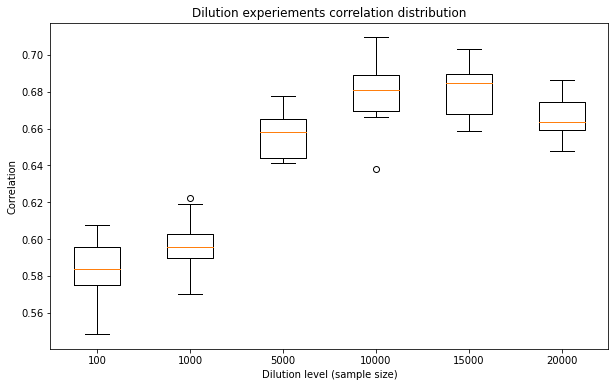

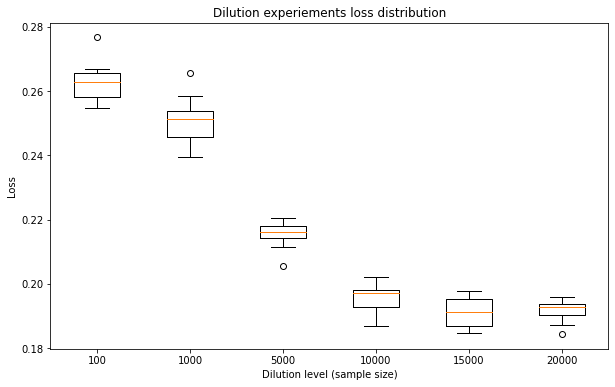

In [7]:
plot_box_metrics(results)


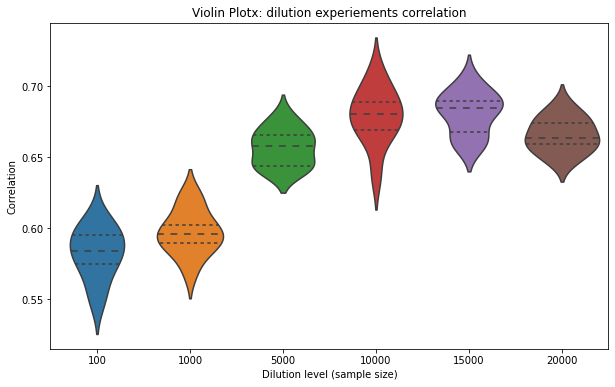

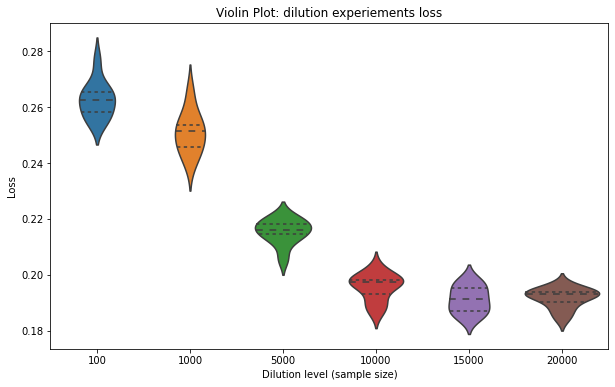

In [8]:
plot_violin_metrics(results)

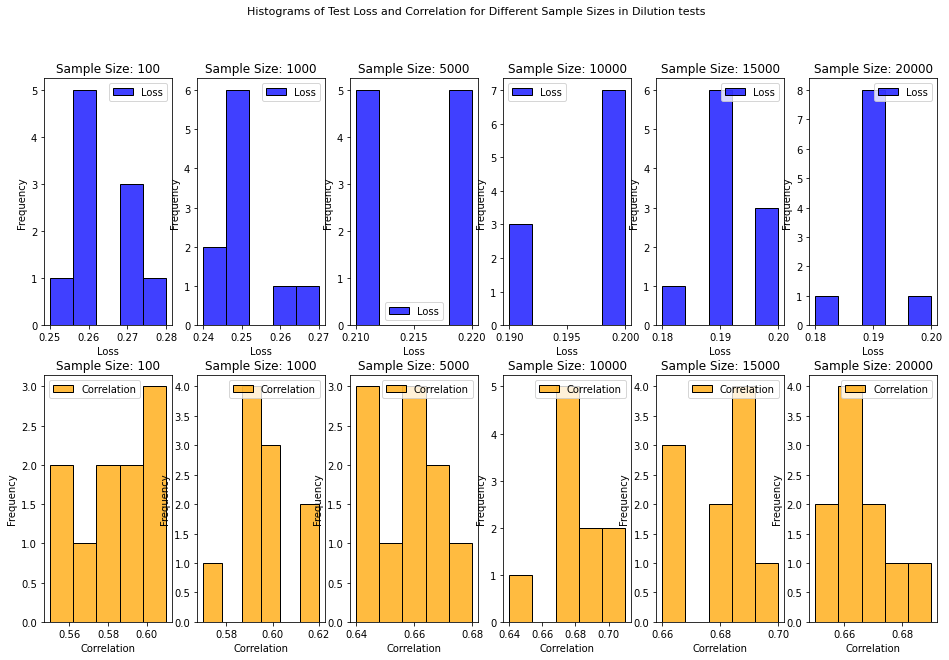

In [9]:
plot_histograms(results)
